# Preprocess the complex crystal structure from the PDB and convert it for FMO calculations.
I referred to [T019 · Molecular Dynamics Simulation](https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html).
This [Japanese article](https://magattaca.hatenablog.com/entry/2022/05/02/005819) is also a useful reference.

In [1]:
import copy
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import pdbfixer
import mdtraj as md
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [7]:
pdbfile = "../tests/5law.pdb"
ligand_name = "6SJ"
smiles = "OC(=O)CN1CC[C@H]2[C@@H]1[C@H](c3cccc(Cl)c3)[C@@]4(N2CC5CC5)C(=O)Nc6cc(Cl)ccc46"

In [8]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [9]:
prepared_protein = prepare_protein(pdbfile, ignore_missing_residues=False)

In [10]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand2 = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand2)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand2

[23:36:05] WARNING: More than one matching pattern found - picking one



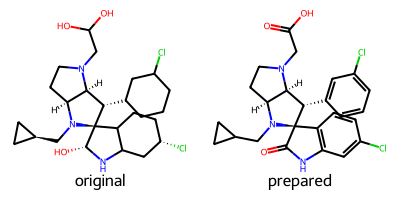

In [11]:
rdkit_ligand = prepare_ligand(pdbfile, ligand_name, smiles)

In [12]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    # convert RDKit to OpenFF
    #off_mol = Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True, hydrogens_are_explicit=True)
    off_mol = Molecule.from_rdkit(rdkit_mol)
    

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])
        #print(name, off_atom.name)

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")
    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)
    
    return omm_mol, off_mol

In [13]:
omm_ligand, off_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

In [14]:
def merge_protein_and_ligand(protein, ligand):
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [15]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/Users/kzfm/miniconda3/envs/FMOkit/lib/python3.13/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [16]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")

Complex topology has 1640 atoms.


In [17]:
def generate_forcefield(rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"):
    forcefield = app.ForceField(protein_ff, solvent_ff)
    if rdkit_mol is not None:
        #gaff = GAFFTemplateGenerator(off_mol)
        if rdkit_mol is not None:
            gaff = GAFFTemplateGenerator(
                molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
            )
        forcefield.registerTemplateGenerator(gaff.generator)
    return forcefield

In [18]:
forcefield = generate_forcefield(rdkit_ligand)

In [19]:
modeller = app.Modeller(complex_topology, complex_positions)
#modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

In [20]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

In [21]:
#top = modeller.getTopology()
#pos = modeller.getPositions()
#app.PDBxFile.writeFile(top, pos, open('gaff_complex_processed.cif', 'w'))

In [22]:
def write_mmcif(complex_topology, complex_positions, system, ofile):
    modeller = app.Modeller(complex_topology, complex_positions)
    
    partial_charges = []
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            for atom_index in range(force.getNumParticles()):
                charge, sigma, epsilon = force.getParticleParameters(atom_index)
                partial_charges.append(str(charge)[:-2])
    #print(len(partial_charges),partial_charges)
    with open("temp.cif", "w") as tf:
        app.PDBxFile.writeFile(modeller.topology, modeller.positions, tf)
    
    atom_site_loop_flag = False
    with open(ofile, "w") as wf:
        with open("temp.cif", "r") as f:
            for l in f:
                if (l.startswith("ATOM") or l.startswith("HETATM")) and atom_site_loop_flag == False:
                    wf.write("_atom_site.partial_charge\n")
                    i = 0
                    wf.write(l.rstrip('\n') + f"  {float(partial_charges[i]):7.4f}\n")
                    atom_site_loop_flag = True
                elif (l.startswith("ATOM") or l.startswith("HETATM")) and atom_site_loop_flag == True:
                    i += 1
                    wf.write(l.rstrip('\n') + f"  {float(partial_charges[i]):7.4f}\n")                        
                else:
                    wf.write(l)

In [24]:
write_mmcif(complex_topology, complex_positions, system, "5law_processed.cif")